# ICICI World Cup 2023 Analyst Report


# Introduction


This notebook provides a comprehensive analysis of the ICC Cricket World Cup 2023, covering varrious aspects of batting, bowling, fielding and venue performance. The aim is to generate insights and satistics that contribute to a detailed report on the tournment

# 1. Setup and Data Loading



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
try:
    batting_df = pd.read_csv('/content/drive/MyDrive/ICICI_World-Cup/batting_summary.csv')
    bowling_df = pd.read_csv('/content/drive/MyDrive/ICICI_World-Cup/bowling_summary.csv')
    matches_df = pd.read_csv('/content/drive/MyDrive/ICICI_World-Cup/match_schedule_results.csv')
    players_info_df = pd.read_csv('/content/drive/MyDrive/ICICI_World-Cup/world_cup_players_info.csv')

    print("All datasets loaded successfully.")

except FileNotFoundError as e:
  print(f"Error loading file: {e}. Make sure the CSV files are in the same directory.")
  exit()

# Display the column names and first few rows
print("Batting Summary Head:")
print(batting_df.head())

print("Bowling Summary Head:")
print(bowling_df.head())

print("Match Schedule Head:")
print(matches_df.head())

print("Players Info Head:")
print(players_info_df.head())


All datasets loaded successfully.
Batting Summary Head:
   Match_no           Match_Between Team_Innings    Batsman_Name  \
0         1  England vs New Zealand      England  Jonny Bairstow   
1         1  England vs New Zealand      England     Dawid Malan   
2         1  England vs New Zealand      England        Joe Root   
3         1  England vs New Zealand      England     Harry Brook   
4         1  England vs New Zealand      England       Moeen Ali   

   Batting_Position                            Dismissal  Runs  Balls  4s  6s  \
0                 1  c Daryl Mitchell b Mitchell Santner    33     35   4   1   
1                 2            c Tom Latham b Matt Henry    14     24   2   0   
2                 3                     b Glenn Phillips    77     86   4   1   
3                 4     c Devon Conway b Rachin Ravindra    25     16   4   1   
4                 5                     b Glenn Phillips    11     17   1   0   

  Strike_Rate  
0      94.300  
1      58.300  


# 2.Data Preprocessing and Cleaning


This section handles all data cleaning, standardization and perparation tasks to ensure the datasets are ready for analysis

### 2.1 Columns Name Standardization

In [3]:
# Clean and standardize column names across all datasets
def clean_cols(df):
    """Clean column names: remove spaces, convert to lowercase, remove special characters"""
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)
    return df

batting_df = clean_cols(batting_df)
bowling_df = clean_cols(bowling_df)
matches_df = clean_cols(matches_df)
players_info_df = clean_cols(players_info_df)

### 2.2 Column Renaming for Consistency

In [4]:
# Batting data column renaming
batting_df.rename(columns={
    'match_no': 'match_id',
    'batsman_name': 'batsman',
    'team_innings': 'team',
    'dismissal': 'out_or_not_out',
    'batting_position': 'position'
}, inplace=True)

# Bowling data column renaming
bowling_df.rename(columns={
    'match_no': 'match_id',
    'bowler_name': 'bowler',
    'bowling_team': 'team'
}, inplace=True)

# Matches data column renaming
matches_df.rename(columns={
    'match_no': 'match_id',
    'date': 'date',
    'venue': 'venue',
    'team1': 'team_1',
    'team2': 'team_2',
    'winner': 'winner'
}, inplace=True)

# Players info column renaming
players_info_df.rename(columns={
    'player_name': 'player_name',
    'team_name': 'country',
    'playingrole': 'role'
}, inplace=True)

### 2.3 Data Cleaning and Text Processing

In [5]:
# Remove extra spaces from team names in matches data
matches_df['team_1'] = matches_df['team_1'].str.strip()
matches_df['team_2'] = matches_df['team_2'].str.strip()
matches_df['winner'] = matches_df['winner'].str.strip()

# Create standardized dismissal status for batting data
# If dismissal is NaN, empty, or contains 'not out', then 'not out', otherwise 'out'
batting_df['out_or_not_out'] = batting_df['out_or_not_out'].apply(
    lambda x: 'not out' if (pd.isna(x) or str(x).strip() == '' or 'not out' in str(x).lower()) else 'out'
)

# Clean player names (remove extra spaces)
batting_df['batsman'] = batting_df['batsman'].str.strip()
bowling_df['bowler'] = bowling_df['bowler'].str.strip()
players_info_df['player_name'] = players_info_df['player_name'].str.strip()

### 2.4 Data Integration and Merging

In [6]:
# Merge batting data with player info to get team/country information
batting_df = pd.merge(
    batting_df,
    players_info_df[['player_name', 'country', 'role']],
    left_on='batsman',
    right_on='player_name',
    how='left'
)
batting_df.rename(columns={'country': 'batsman_country', 'role': 'batsman_role'}, inplace=True)
batting_df.drop(columns=['player_name'], inplace=True)

# Merge bowling data with player info to get team/country information
bowling_df = pd.merge(
    bowling_df,
    players_info_df[['player_name', 'country', 'role']],
    left_on='bowler',
    right_on='player_name',
    how='left'
)
bowling_df.rename(columns={'country': 'bowler_country', 'role': 'bowler_role'}, inplace=True)
bowling_df.drop(columns=['player_name'], inplace=True)

# Check for any missing team information
batting_missing = batting_df['batsman_country'].isna().sum()
bowling_missing = bowling_df['bowler_country'].isna().sum()

if batting_missing > 0 or bowling_missing > 0:
    print(f"Warning: {batting_missing} batting records and {bowling_missing} bowling records missing team info")
else:
    print("All players successfully matched with team information")

All players successfully matched with team information


### 2.5 Numeric Data Type Conversion

In [7]:
# Convert batting statistics to appropriate numeric data types

numeric_cols_batting = ['runs', 'balls', '4s', '6s', 'strike_rate']

for col in numeric_cols_batting:
    if col in batting_df.columns:
        batting_df[col] = pd.to_numeric(batting_df[col], errors='coerce')

# Rename boundary columns for consistency
batting_df.rename(columns={'4s': 'fours', '6s': 'sixes'}, inplace=True)

### 2.6 Date Processing and Innings Assignment

In [26]:
# Convert 'date' column in matches_df to datetime
matches_df['date'] = pd.to_datetime(matches_df['date'], errors='coerce')

# Add innings information to batting data based on team batting order
# Assumption: Team_1 bats first (innings 1), Team_2 bats second (innings 2)
batting_df = pd.merge(batting_df, matches_df[['match_id', 'team_1', 'team_2']], on='match_id', how='left')

def get_innings(row):
    if row['team'] == row['team_1']:
        return 1
    elif row['team'] == row['team_2']:
        return 2
    else:
        return 1  # default

batting_df['innings'] = batting_df.apply(get_innings, axis=1)
batting_df.drop(columns=['team_1', 'team_2'], inplace=True)

### 2.7 Data Preprocessing Summary

In [27]:
print("The data after processing:")

print("Batting Summary")
print(batting_df.head())

print("Bowling Summary")
print(bowling_df.head())

print("Match Schedule")
print(matches_df.head())

print("Players Info:")
print(players_info_df.head())

The data after processing:
Batting Summary
   match_id           match_between     team         batsman  position  \
0         1  England vs New Zealand  England  Jonny Bairstow         1   
1         1  England vs New Zealand  England     Dawid Malan         2   
2         1  England vs New Zealand  England        Joe Root         3   
3         1  England vs New Zealand  England     Harry Brook         4   
4         1  England vs New Zealand  England       Moeen Ali         5   

  out_or_not_out  runs  balls  fours  sixes  strike_rate batsman_country  \
0            out    33     35      4      1         94.3         England   
1            out    14     24      2      0         58.3         England   
2            out    77     86      4      1         89.5         England   
3            out    25     16      4      1        156.3         England   
4            out    11     17      1      0         64.7         England   

          batsman_role  innings  batting_order       ba

## 3. Team Analysis

#### Calculate wins for each team

Team Win Percentage:
                      Team  Wins  Matches Played      Win %
winner                                                     
Australia        Australia     9              11  81.818182
India                India     9              11  81.818182
South Africa  South Africa     7              10  70.000000
New Zealand    New Zealand     5              10  50.000000
Pakistan          Pakistan     4               9  44.444444
Afghanistan    Afghanistan     4               9  44.444444
Sri Lanka        Sri Lanka     3               9  33.333333
England            England     3               9  33.333333
Bangladesh      Bangladesh     2               9  22.222222
Netherlands    Netherlands     2               9  22.222222


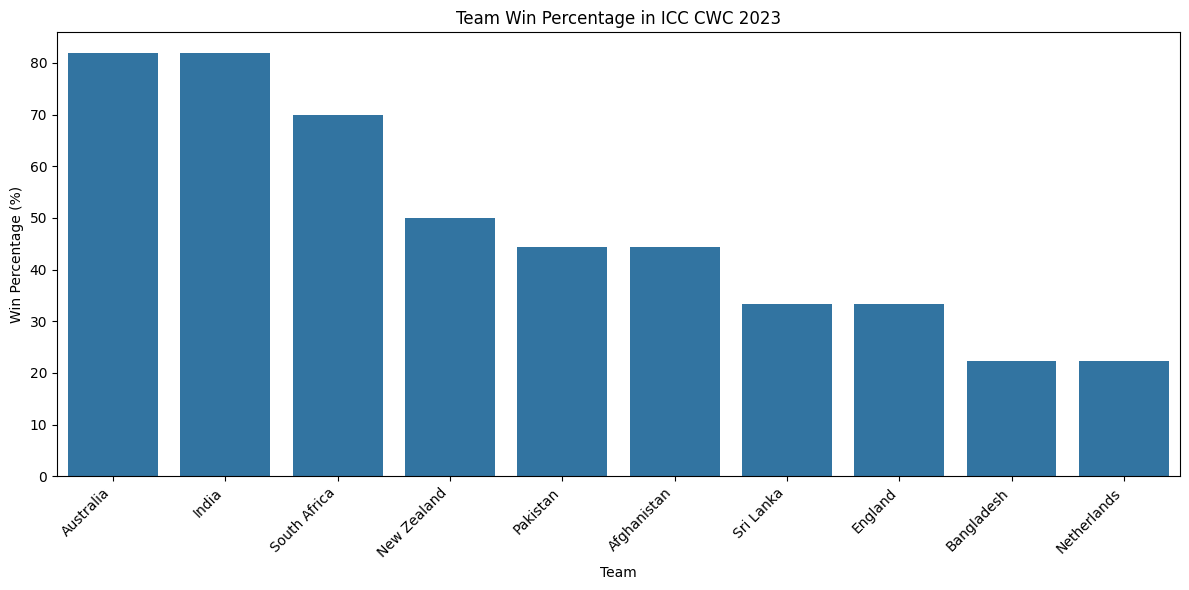

In [11]:
# Calculate wins for each team
team_wins = matches_df['winner'].value_counts()

# Calculate total matches played by each team using melt operation
team1_matches = matches_df[['team_1']].rename(columns={'team_1': 'team'})
team2_matches = matches_df[['team_2']].rename(columns={'team_2': 'team'})
all_team_matches = pd.concat([team1_matches, team2_matches])
team_matches_played = all_team_matches['team'].value_counts()

# Create win percentage DataFrame directly
win_percentage_df = pd.DataFrame({
    'Team': team_wins.index,
    'Wins': team_wins.values,
    'Matches Played': team_wins.index.map(team_matches_played),
    'Win %': (team_wins / team_wins.index.map(team_matches_played) * 100)
}).sort_values(by='Win %', ascending=False)

print("Team Win Percentage:")
print(win_percentage_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=win_percentage_df, x='Team', y='Win %')
plt.title('Team Win Percentage in ICC CWC 2023')
plt.ylabel('Win Percentage (%)')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Batting Strength and Depth

#### 4.1 Average Runs Per Wicket by Batting Order

In [12]:
# Data preparation: Create batting order groups
# Ensure batting order is numeric and handle missing values
batting_df['batting_order'] = pd.to_numeric(batting_df['position'], errors='coerce').fillna(99)

def get_batting_group(order):
    """Categorize batting position into groups"""
    if order <= 3:
        return 'Top Order (1-3)'
    elif order <= 7:
        return 'Middle Order (4-7)'
    else:
        return 'Lower Order (8+)'

# Create batting group column
batting_df['batting_group'] = batting_df['batting_order'].apply(get_batting_group)

print("Batting order groups created successfully!")
print("\nBatting group distribution:")
print(batting_df['batting_group'].value_counts())

Batting order groups created successfully!

Batting group distribution:
batting_group
Middle Order (4-7)    361
Top Order (1-3)       300
Lower Order (8+)      255
Name: count, dtype: int64


#### 4.2 Calculate average runs per wicket by team

Average Runs Per Wicket by Team:
           team  runs_per_wicket
0   New Zealand        68.889740
1         India        65.152273
2      Pakistan        56.056349
3   Afghanistan        51.717593
4     Australia        45.013440
5  South Africa        42.984080
6     Sri Lanka        31.546914
7    Bangladesh        27.102469
8       England        25.288889
9   Netherlands        19.791667


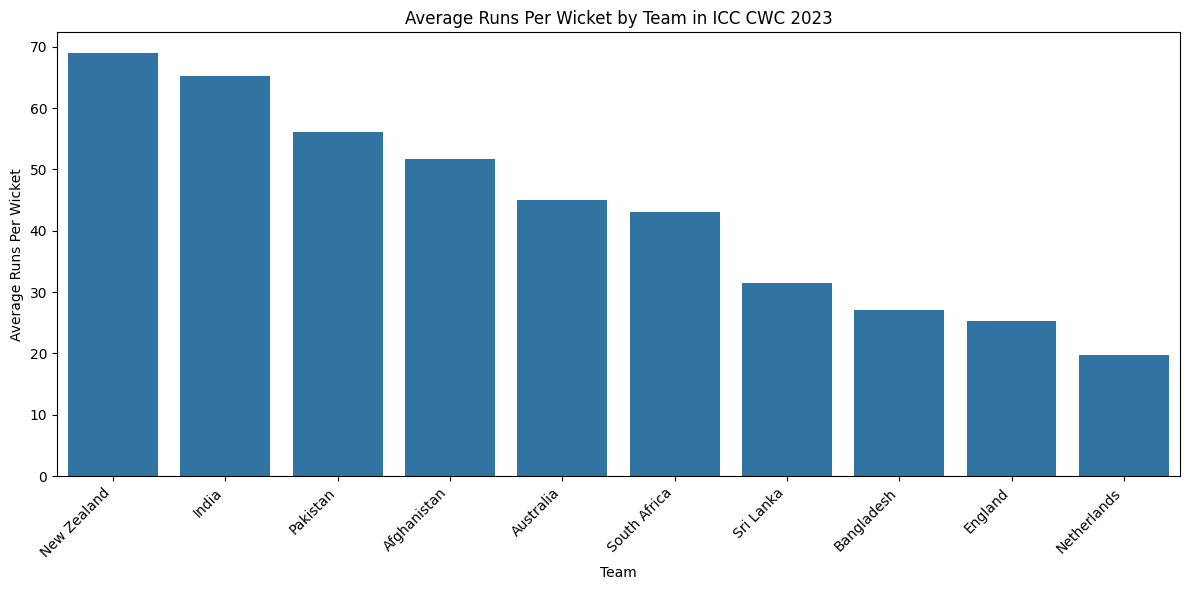

In [28]:
# Calculate average runs per wicket by team
avg_runs_per_wicket_team = (team_innings_summary
                           .groupby('team')['runs_per_wicket']
                           .mean()
                           .sort_values(ascending=False)
                           .reset_index())

print("Average Runs Per Wicket by Team:")
print(avg_runs_per_wicket_team)

# Visualize team performance
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_runs_per_wicket_team, x='team', y='runs_per_wicket')
plt.title('Average Runs Per Wicket by Team in ICC CWC 2023')
plt.ylabel('Average Runs Per Wicket')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Most Centuries and Half-Centuries

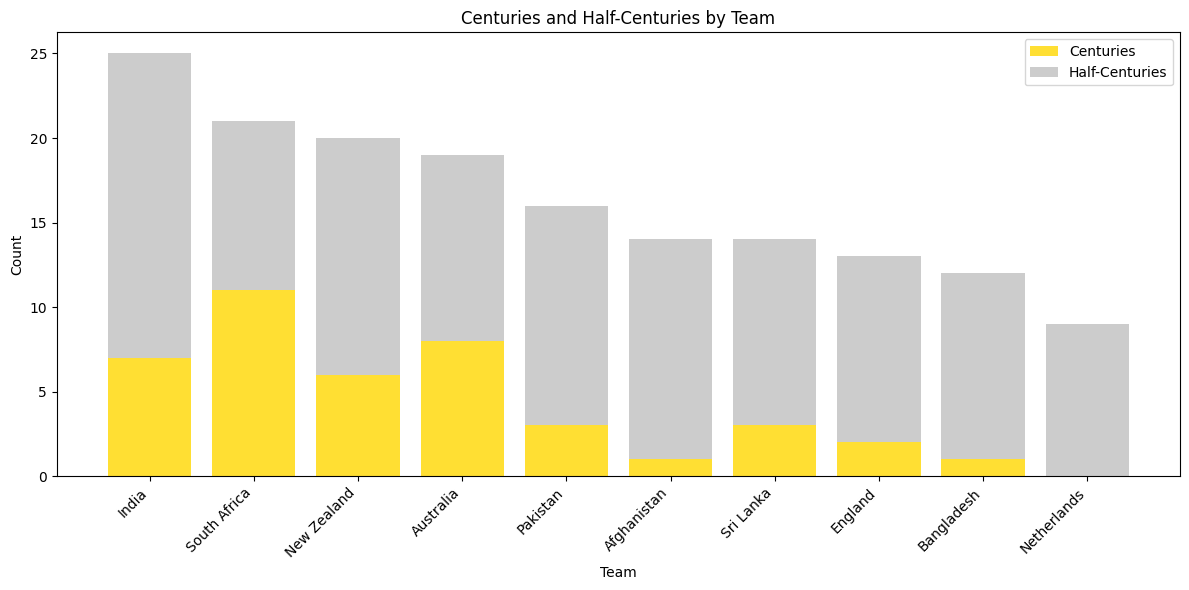

In [ ]:
# Count centuries and half-centuries by team
centuries = batting_df[batting_df['runs'] >= 100].groupby('team').size().sort_values(ascending=False).reset_index(name='Centuries')
half_centuries = batting_df[(batting_df['runs'] >= 50) & (batting_df['runs'] < 100)].groupby('team').size().sort_values(ascending=False).reset_index(name='Half-Centuries')

# Merge the data
centuries_half_centuries = pd.merge(centuries, half_centuries, on='team', how='outer').fillna(0)
centuries_half_centuries['Total 50+ Scores'] = centuries_half_centuries['Centuries'] + centuries_half_centuries['Half-Centuries']
centuries_half_centuries = centuries_half_centuries.sort_values(by='Total 50+ Scores', ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
x_pos = range(len(centuries_half_centuries))
plt.bar(x_pos, centuries_half_centuries['Centuries'], label='Centuries', alpha=0.8, color='gold')
plt.bar(x_pos, centuries_half_centuries['Half-Centuries'], bottom=centuries_half_centuries['Centuries'],
        label='Half-Centuries', alpha=0.8, color='silver')

plt.title('Centuries and Half-Centuries by Team')
plt.ylabel('Count')
plt.xlabel('Team')
plt.xticks(x_pos, centuries_half_centuries['team'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Bowling Strength

#### Total wickets by team

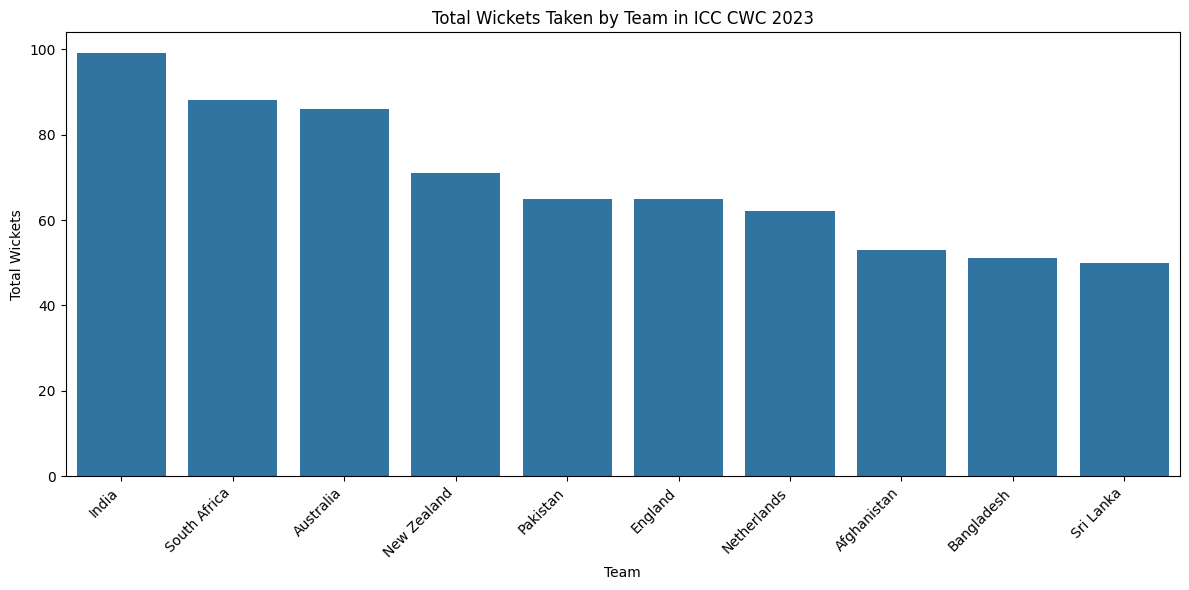

In [ ]:
# Total wickets by team
total_wickets_by_team = bowling_df.groupby('team')['wickets'].sum().sort_values(ascending=False).reset_index()
total_wickets_by_team.rename(columns={'team': 'Team'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=total_wickets_by_team, x='Team', y='wickets')
plt.title('Total Wickets Taken by Team in ICC CWC 2023')
plt.ylabel('Total Wickets')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 7 Teams Bowling Out Opposition Most Frequently

#### 7.1 Economy Rate Analysis

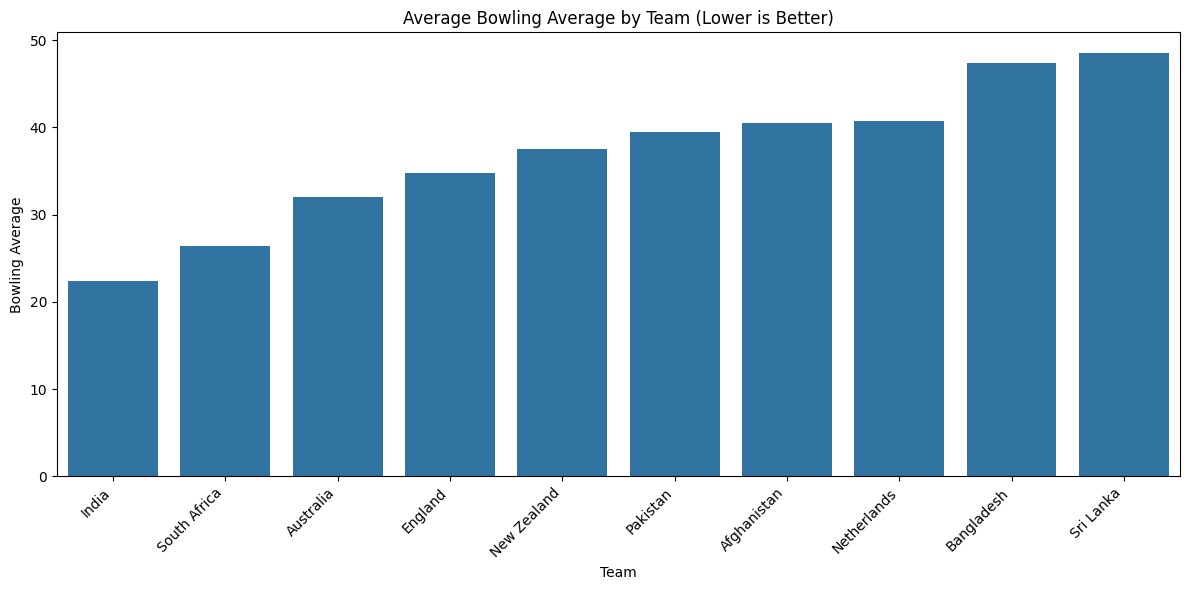

In [17]:
avg_sorted = team_bowling_stats[team_bowling_stats['total_wickets'] >= 5].sort_values(by='average_bowling_avg')

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sorted, x='Team', y='average_bowling_avg')
plt.title('Average Bowling Average by Team (Lower is Better)')
plt.ylabel('Bowling Average')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Strike Rate Analysis

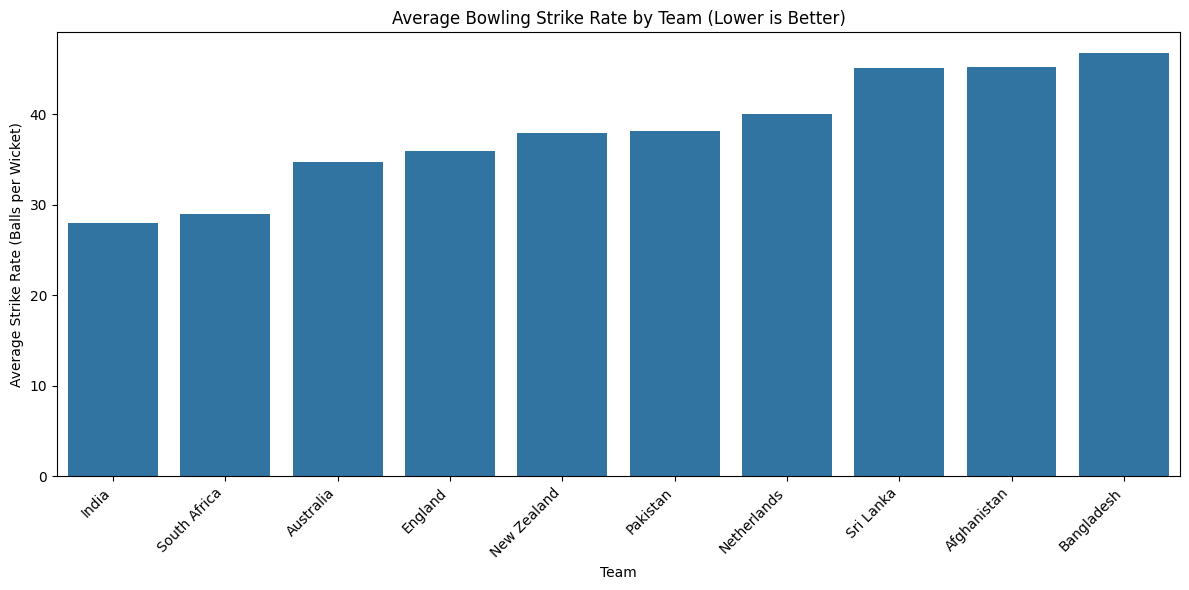

In [29]:
sr_sorted = team_bowling_stats[team_bowling_stats['total_wickets'] >= 5].sort_values(by='average_strike_rate')

plt.figure(figsize=(12, 6))
sns.barplot(data=sr_sorted, x='Team', y='average_strike_rate')
plt.title('Average Bowling Strike Rate by Team (Lower is Better)')
plt.ylabel('Average Strike Rate (Balls per Wicket)')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8 Top 10 by total runs

#### Top 10 Run Scorers

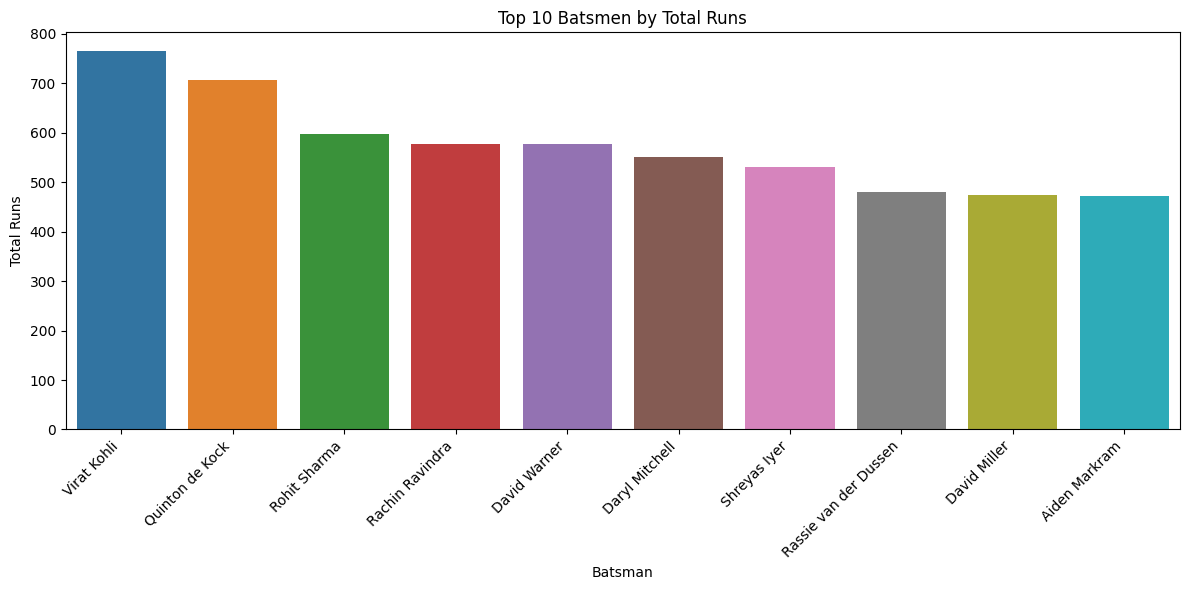

In [ ]:
# Top 10 by total runs
top_runs = batsman_stats.nlargest(10, 'total_runs')[['Batsman_Name', 'total_runs', 'average', 'strike_rate', 'hundreds', 'fifties']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_runs, x='Batsman_Name', y='total_runs', hue='Batsman_Name', legend=False)
plt.title('Top 10 Batsmen by Total Runs')
plt.ylabel('Total Runs')
plt.xlabel('Batsman')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 8.1 Highest Batting Averages

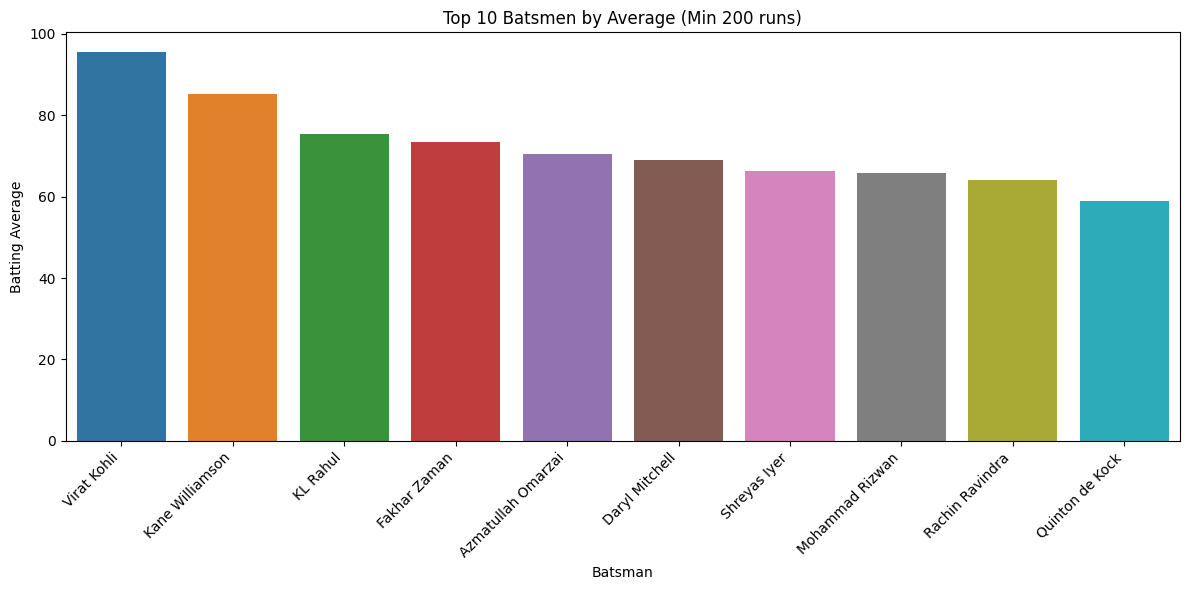

In [ ]:
# Top 10 by batting average (minimum 200 runs)
top_avg = batsman_stats[batsman_stats['total_runs'] >= 200].nlargest(10, 'average')[['Batsman_Name', 'total_runs', 'average', 'strike_rate', 'times_out']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_avg, x='Batsman_Name', y='average', hue='Batsman_Name', legend=False)
plt.title('Top 10 Batsmen by Average (Min 200 runs)')
plt.ylabel('Batting Average')
plt.xlabel('Batsman')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Top 10 Bowlers

#### Best Economy Rates

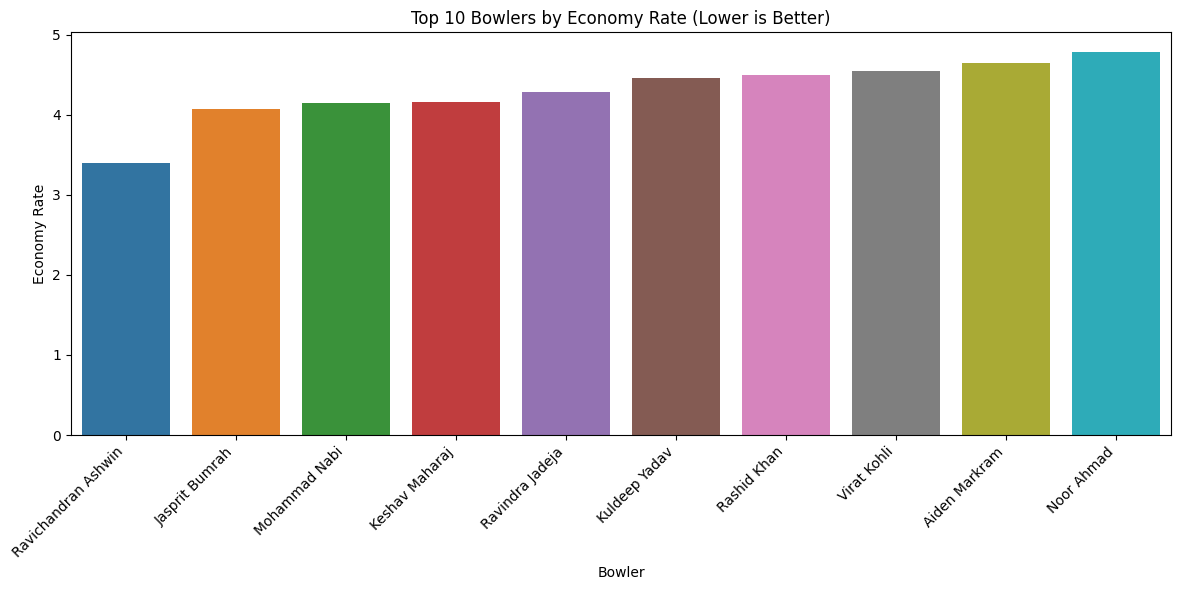

In [30]:
# Top 10 by economy rate
best_economy = bowler_stats.nsmallest(10, 'economy_rate')[['bowler', 'total_wickets', 'bowling_average', 'economy_rate', 'total_maidens']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=best_economy, x='bowler', y='economy_rate', hue='bowler', legend=False)
plt.title('Top 10 Bowlers by Economy Rate (Lower is Better)')
plt.ylabel('Economy Rate')
plt.xlabel('Bowler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Best Strike Rates

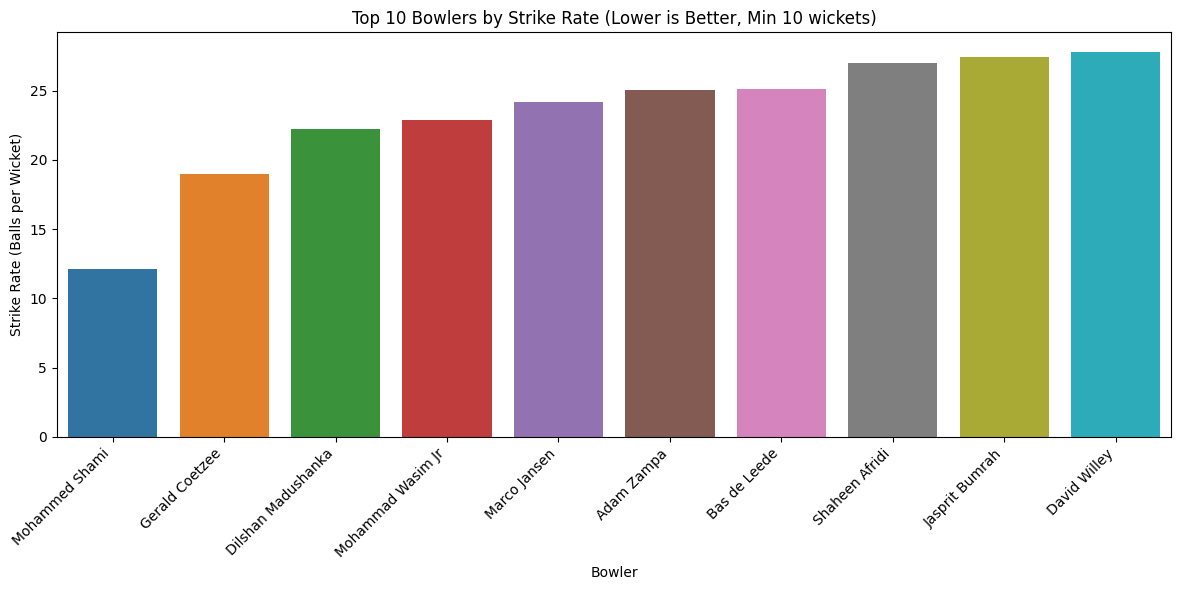

In [25]:
# Top 10 by strike rate (minimum 10 wickets)
best_sr = bowler_stats[bowler_stats['total_wickets'] >= 10].nsmallest(10, 'strike_rate')[['bowler', 'total_wickets', 'bowling_average', 'economy_rate', 'strike_rate']]

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=best_sr, x='bowler', y='strike_rate', hue='bowler', legend=False)
plt.title('Top 10 Bowlers by Strike Rate (Lower is Better, Min 10 wickets)')
plt.ylabel('Strike Rate (Balls per Wicket)')
plt.xlabel('Bowler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()